In [ ]:
!pip install wntr numpy==1.26.4

In [ ]:
!pip install networkx pandas scikit-learn matplotlib

In [ ]:
# Importing required libraries
import wntr
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import io
from collections import Counter

/usr/local/lib/python3.11/dist-packages/wntr/epanet/io.py:2082: UserWarning: Not all curves were used in "CTOWN.INP"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
<ipython-input-5-014f20823a28>:8: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph().to_undirected()


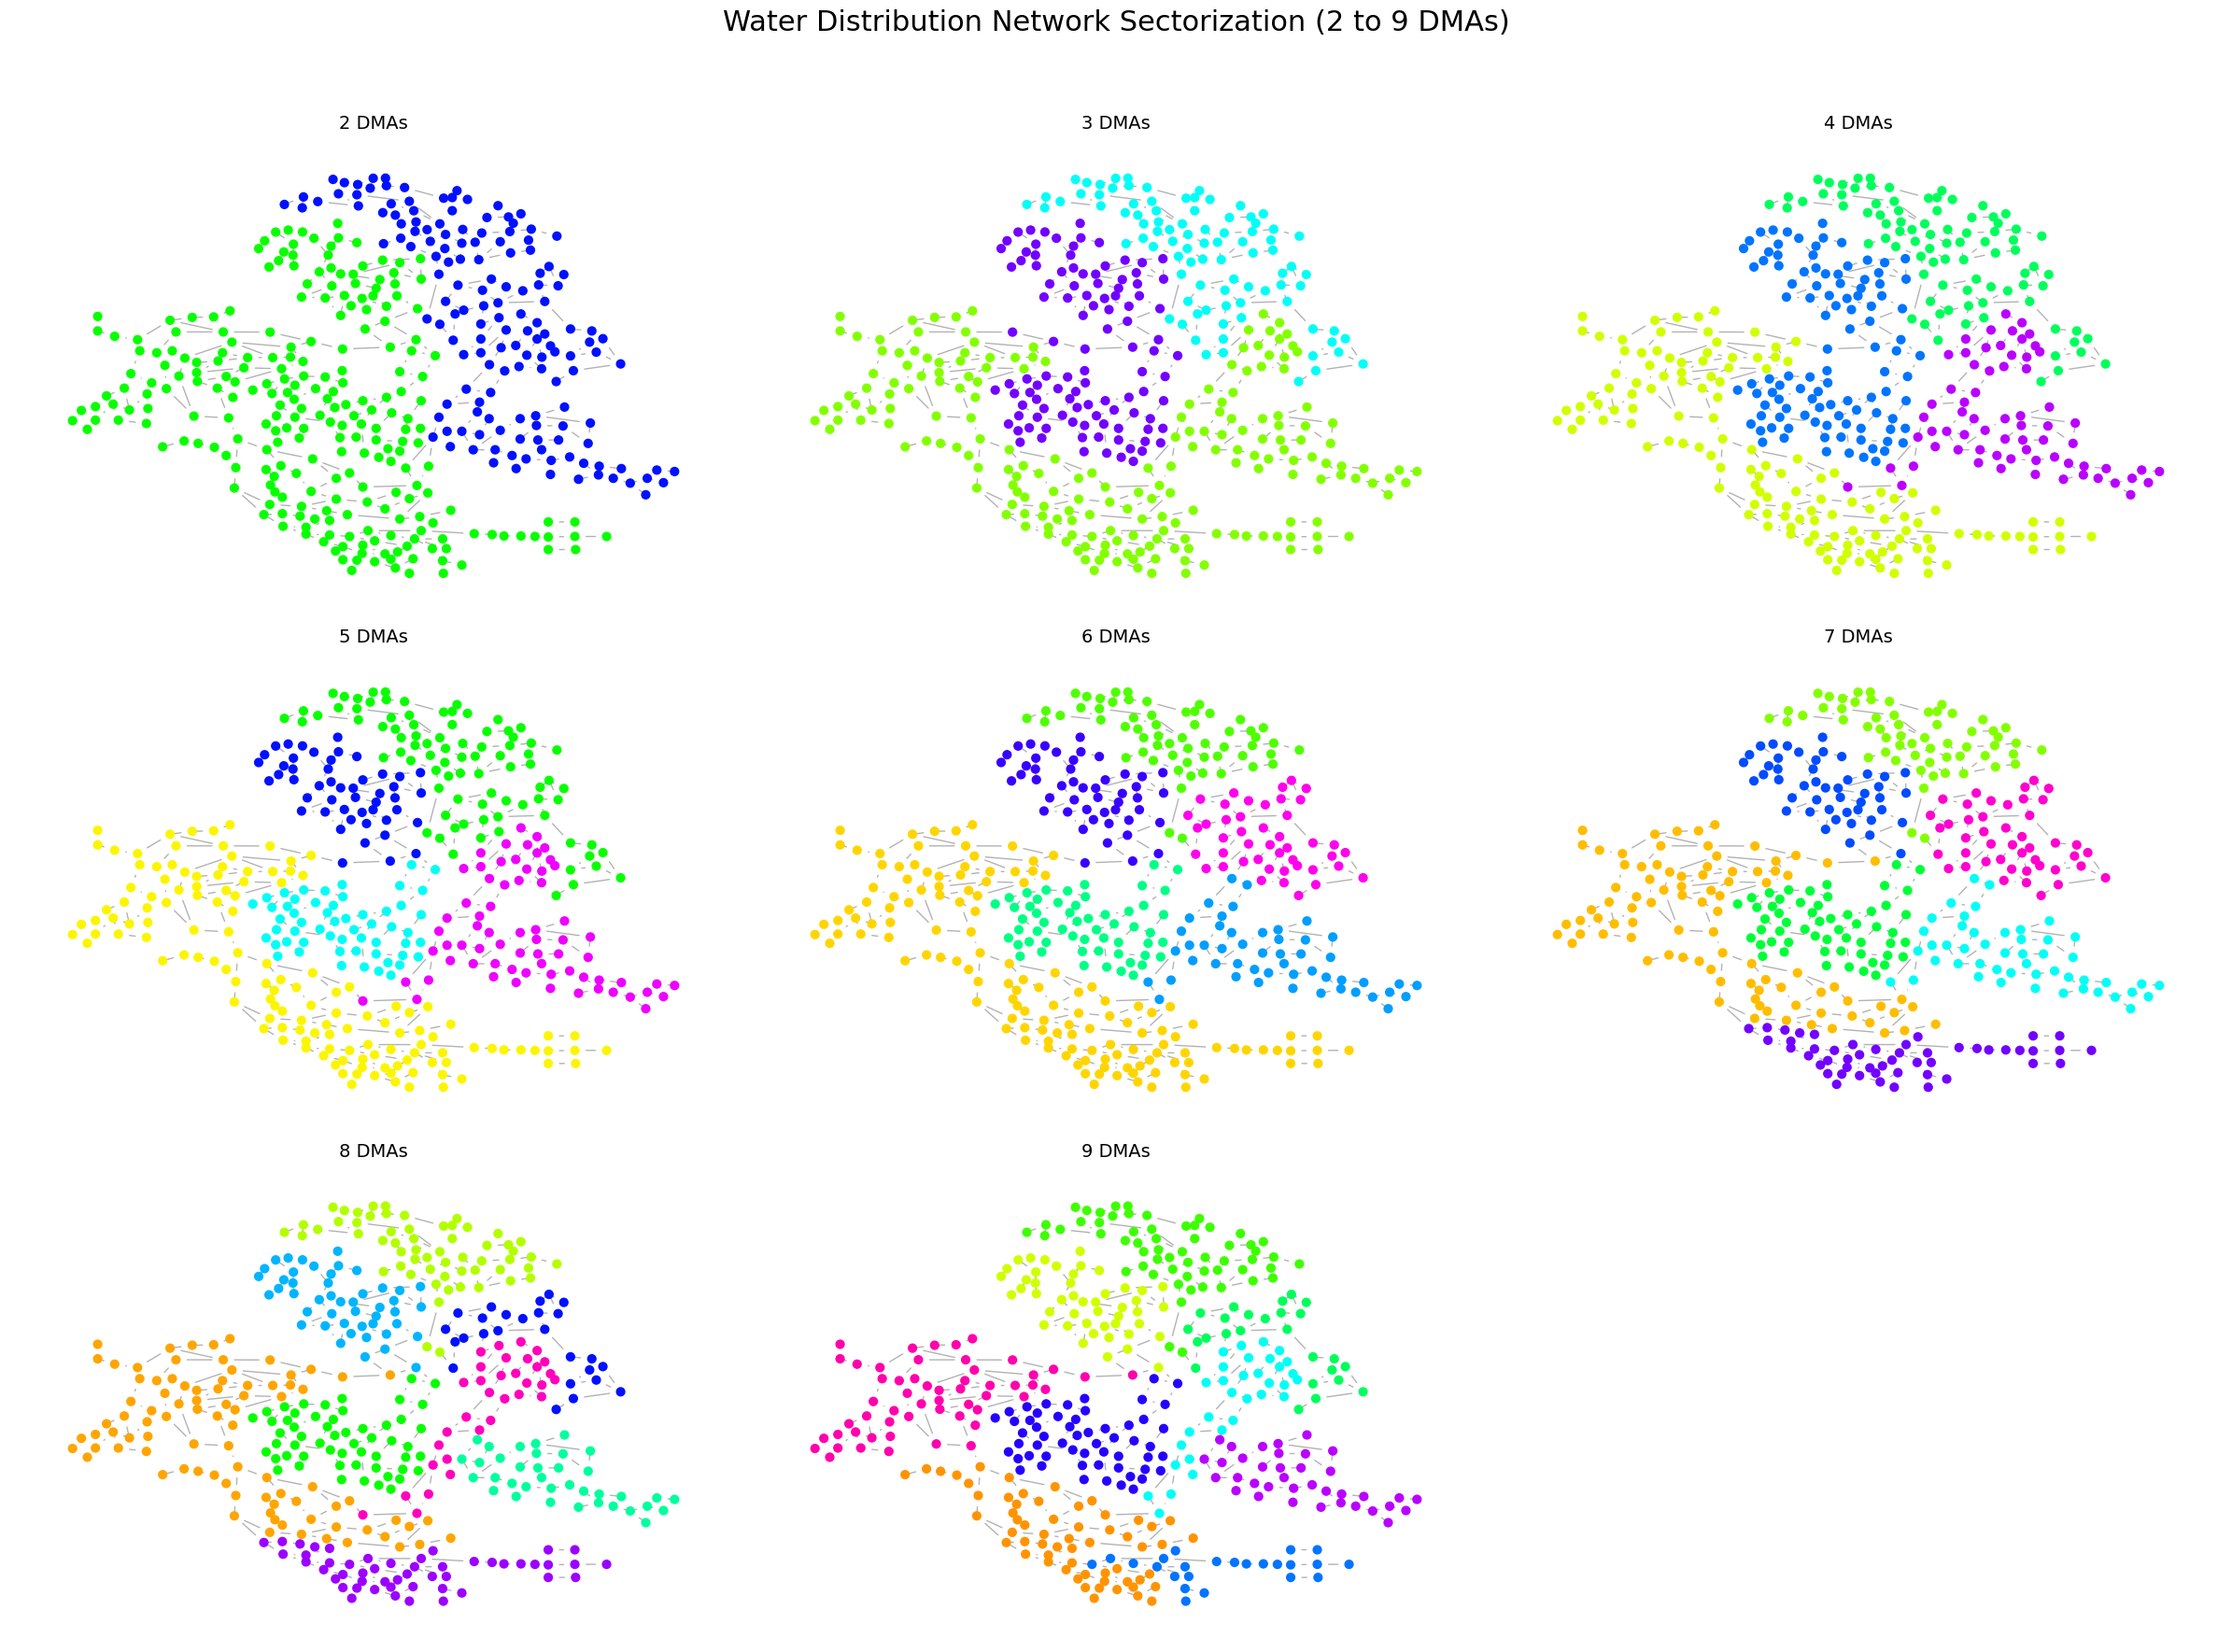

<ipython-input-5-014f20823a28>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Degree_Centrality', ax=ax2[0], palette='Blues')
<ipython-input-5-014f20823a28>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Closeness_Centrality', ax=ax2[1], palette='Greens')
<ipython-input-5-014f20823a28>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Betweenness_Centrality', ax=ax2[2], palette='Oranges')


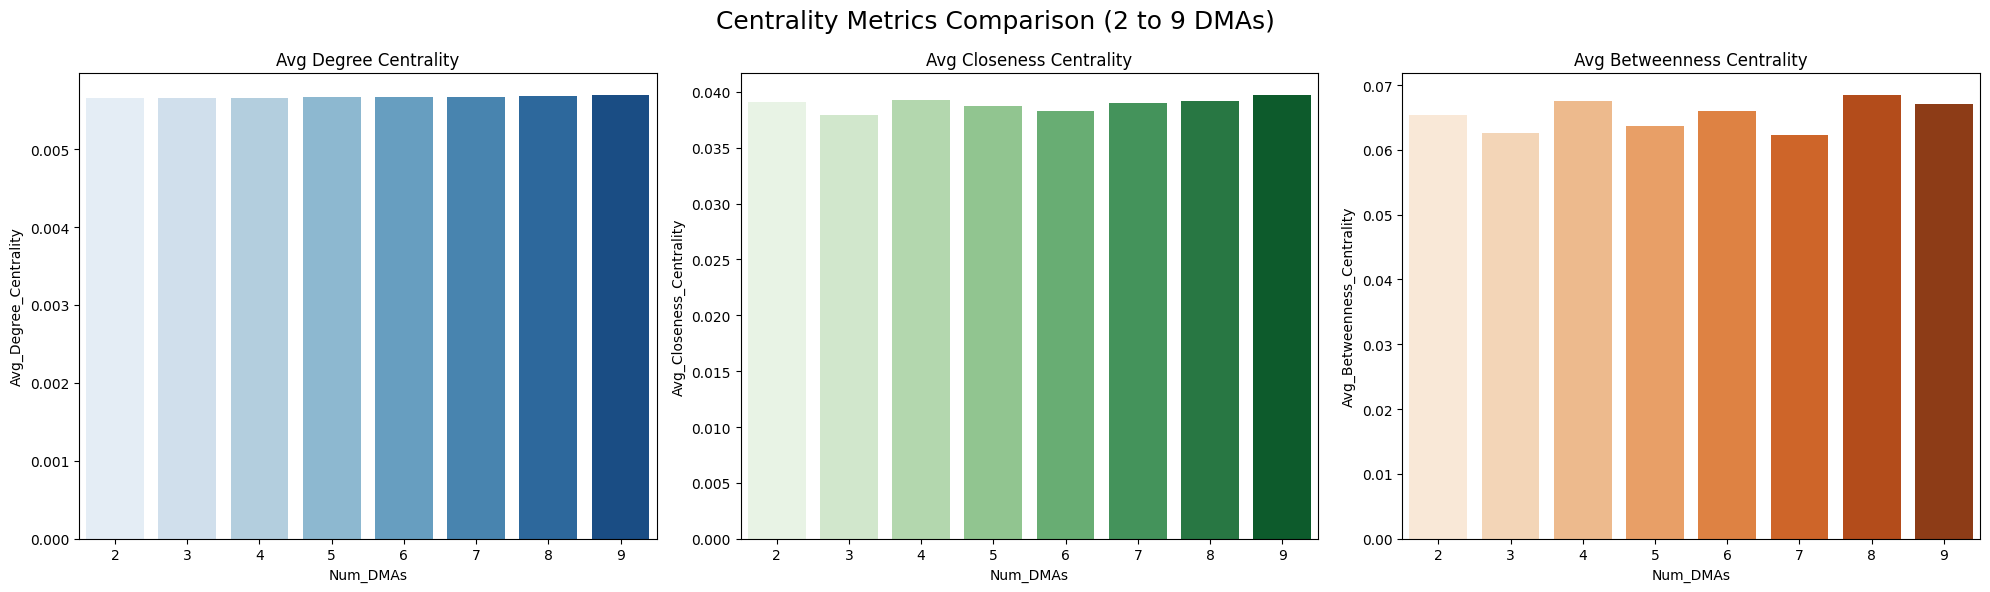


✅ Excel file 'DMA_Centrality_Comparison.xlsx' created and ready for download.


In [ ]:

from collections import defaultdict

# Loading EPANET INP file
inp_file = "CTOWN.INP"
wn = wntr.network.WaterNetworkModel(inp_file)

# Building Graph & Get Coordinates
G = wn.get_graph().to_undirected()
pos = {node_name: (node.coordinates[0], node.coordinates[1]) for node_name, node in wn.nodes()}

# Creating Adjacency Matrix
adj_matrix = nx.to_numpy_array(G)

# Preparing plot layout
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

# Preparing storage for centrality comparison
centrality_summary = []

# Looping through 2 to 9 clusters
for idx, num_clusters in enumerate(range(2, 10)):
    # Spectral clustering
    sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize', random_state=42)
    labels = sc.fit_predict(adj_matrix)

    # Assigning labels
    dma_labels = {node: label for node, label in zip(G.nodes(), labels)}

    # Visualization
    palette = sns.color_palette("hsv", num_clusters)
    node_colors = [palette[dma_labels[node]] for node in G.nodes()]
    ax = axes[idx]
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, ax=ax)
    ax.set_title(f'{num_clusters} DMAs', fontsize=14)
    ax.axis('off')

    # Centrality metrics
    deg_centrality = nx.degree_centrality(G)
    clo_centrality = nx.closeness_centrality(G)
    bet_centrality = nx.betweenness_centrality(G)

    # Group centralities by DMA
    dma_degrees = defaultdict(list)
    dma_closeness = defaultdict(list)
    dma_betweenness = defaultdict(list)

    for node in G.nodes():
        cluster = dma_labels[node]
        dma_degrees[cluster].append(deg_centrality[node])
        dma_closeness[cluster].append(clo_centrality[node])
        dma_betweenness[cluster].append(bet_centrality[node])

    avg_deg = np.mean([np.mean(vals) for vals in dma_degrees.values()])
    avg_clo = np.mean([np.mean(vals) for vals in dma_closeness.values()])
    avg_bet = np.mean([np.mean(vals) for vals in dma_betweenness.values()])

    centrality_summary.append({
        'Num_DMAs': num_clusters,
        'Avg_Degree_Centrality': avg_deg,
        'Avg_Closeness_Centrality': avg_clo,
        'Avg_Betweenness_Centrality': avg_bet
    })

# Cleaning up unused subplots
for j in range(len(range(2, 10)), len(axes)):
    axes[j].axis('off')

plt.suptitle("Water Distribution Network Sectorization (2 to 9 DMAs)", fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Converting summary to DataFrame
centrality_df = pd.DataFrame(centrality_summary)

# Plotting comparison bar charts
fig2, ax2 = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Degree_Centrality', ax=ax2[0], palette='Blues')
ax2[0].set_title('Avg Degree Centrality')

sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Closeness_Centrality', ax=ax2[1], palette='Greens')
ax2[1].set_title('Avg Closeness Centrality')

sns.barplot(data=centrality_df, x='Num_DMAs', y='Avg_Betweenness_Centrality', ax=ax2[2], palette='Oranges')
ax2[2].set_title('Avg Betweenness Centrality')

plt.suptitle("Centrality Metrics Comparison (2 to 9 DMAs)", fontsize=18)
plt.tight_layout()
plt.show()

# Saving to Excel
centrality_df.to_excel("DMA_Centrality_Comparison.xlsx", index=False)
print("\n✅ Excel file 'DMA_Centrality_Comparison.xlsx' created and ready for download.")


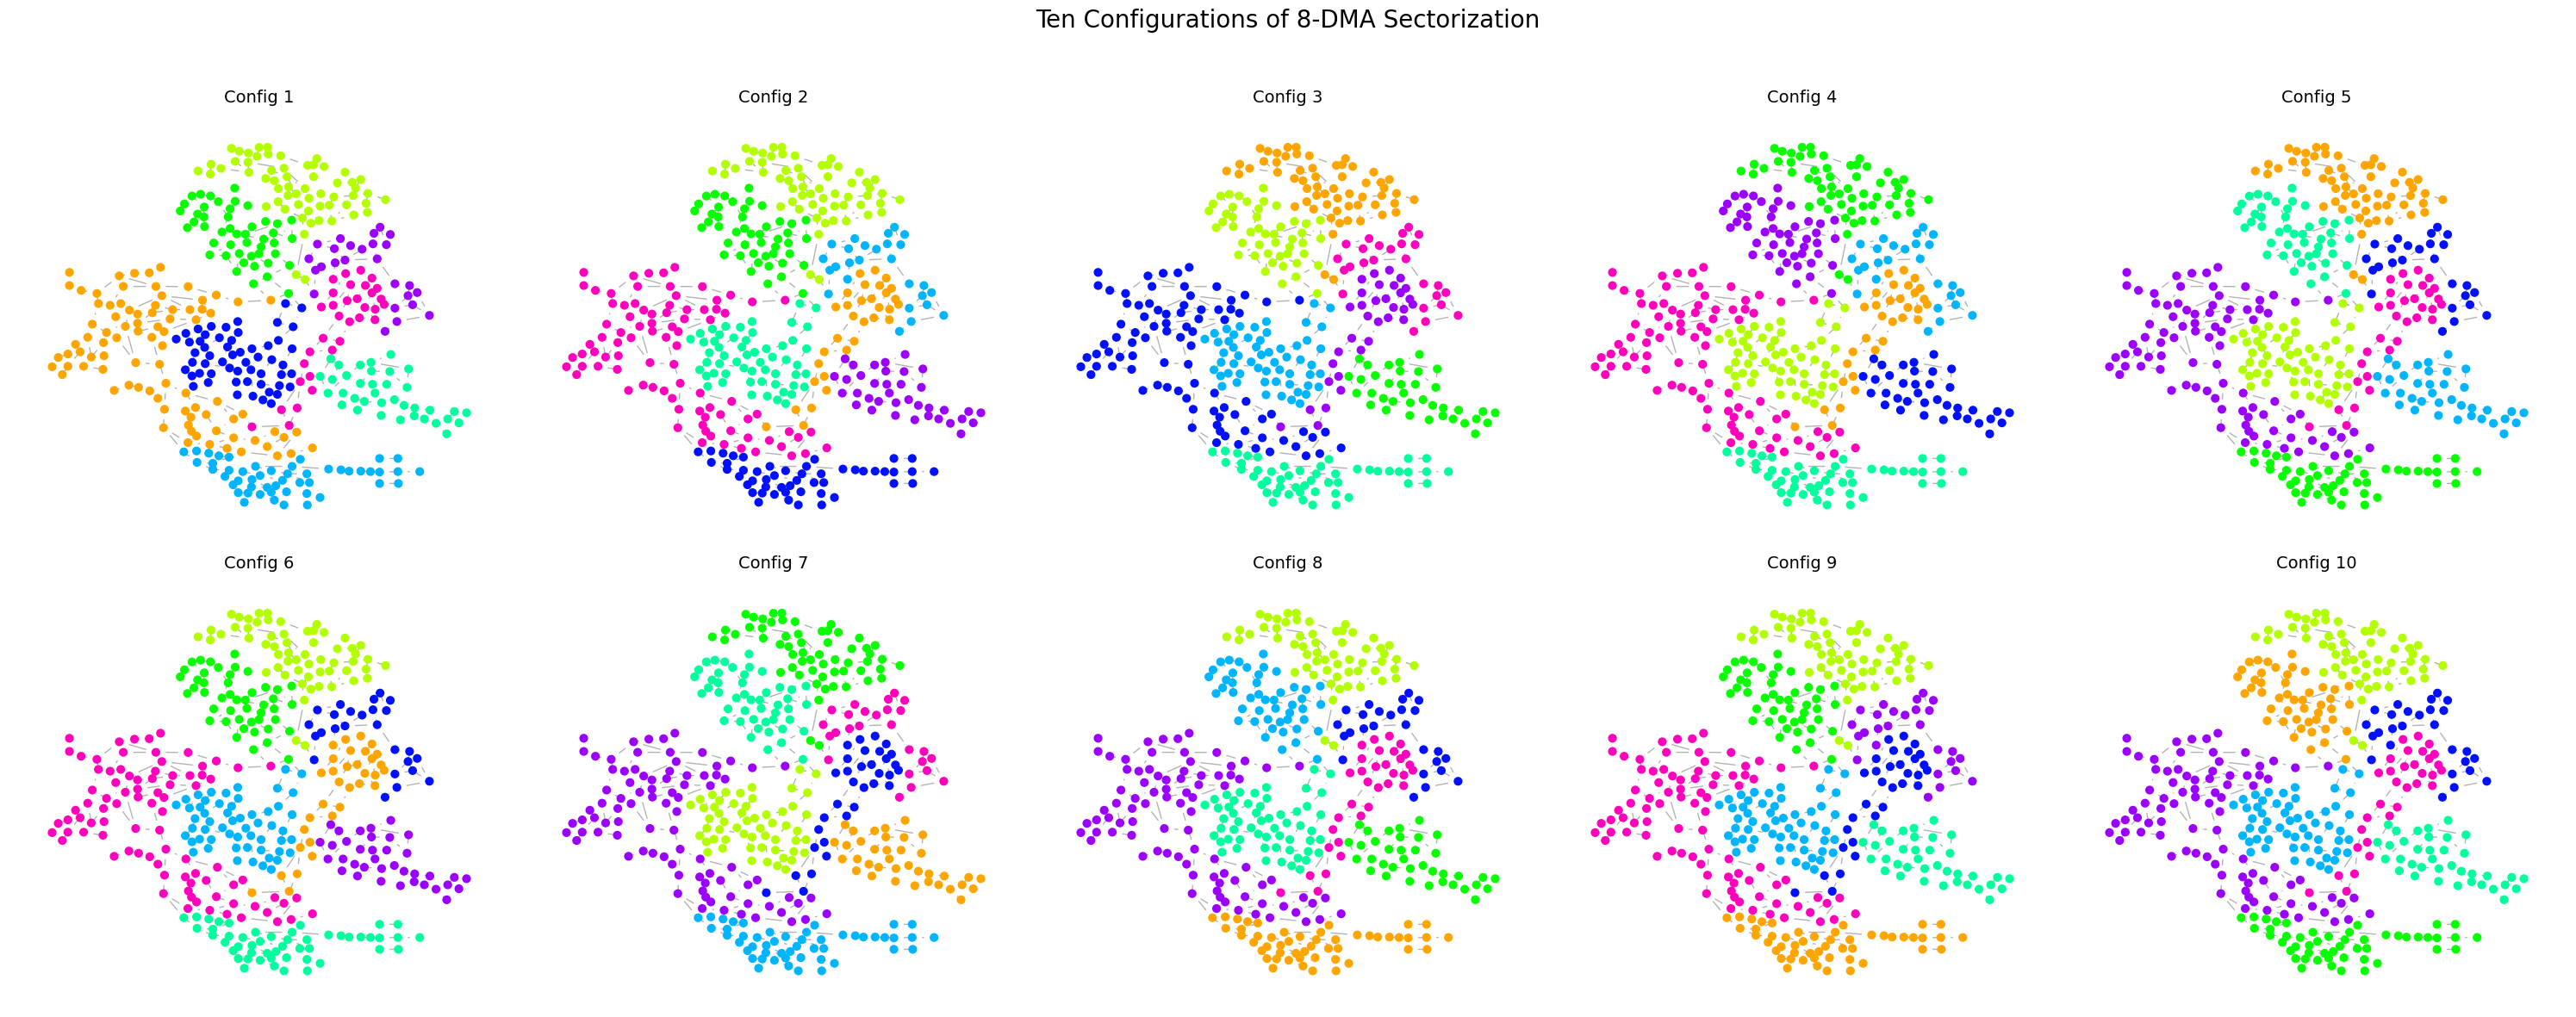

✅ Excel file 'Eight_DMA_Configurations_Centrality.xlsx' saved.


In [ ]:

from collections import defaultdict
import random

# ========== Assumptions ==========
# I already have:
# - G: NetworkX undirected graph from EPANET
# - adj_matrix: precomputed adjacency matrix
# - pos: node coordinates as {node: (x, y)}

num_configs = 10
num_clusters = 8

# Storing results
config_results = []

# Setting up visualization grid
fig, axes = plt.subplots(2, 5, figsize=(30, 12))  # 2 rows x 5 columns
axes = axes.flatten()

for run_id in range(1, num_configs + 1):
    random_state = random.randint(0, 10000)

    # Spectral Clustering
    sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize', random_state=random_state)
    labels = sc.fit_predict(adj_matrix)
    dma_labels = {node: label for node, label in zip(G.nodes(), labels)}

    # ========== Visualization ==========
    palette = sns.color_palette("hsv", num_clusters)
    node_colors = [palette[dma_labels[node]] for node in G.nodes()]
    ax = axes[run_id - 1]
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, ax=ax)
    ax.set_title(f'Config {run_id}', fontsize=14)
    ax.axis('off')

    # ========== Centrality Metrics ==========
    deg_centrality = nx.degree_centrality(G)
    clo_centrality = nx.closeness_centrality(G)
    bet_centrality = nx.betweenness_centrality(G)

    dma_degrees = defaultdict(list)
    dma_closeness = defaultdict(list)
    dma_betweenness = defaultdict(list)

    for node in G.nodes():
        cluster = dma_labels[node]
        dma_degrees[cluster].append(deg_centrality[node])
        dma_closeness[cluster].append(clo_centrality[node])
        dma_betweenness[cluster].append(bet_centrality[node])

    avg_deg = np.mean([np.mean(vals) for vals in dma_degrees.values()])
    avg_clo = np.mean([np.mean(vals) for vals in dma_closeness.values()])
    avg_bet = np.mean([np.mean(vals) for vals in dma_betweenness.values()])

    config_results.append({
        'Configuration_ID': f'Config_{run_id}',
        'Avg_Degree_Centrality': avg_deg,
        'Avg_Closeness_Centrality': avg_clo,
        'Avg_Betweenness_Centrality': avg_bet
    })

# Cleaning up any extra axes (if fewer than 10 plots)
for i in range(num_configs, len(axes)):
    axes[i].axis('off')

plt.suptitle("Ten Configurations of 8-DMA Sectorization", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Saving centrality metrics to Excel
centrality_df = pd.DataFrame(config_results)
centrality_df.to_excel("Eight_DMA_Configurations_Centrality.xlsx", index=False)
print("✅ Excel file 'Eight_DMA_Configurations_Centrality.xlsx' saved.")


In [ ]:
# Extracting node elevations
elevations = {name: node.elevation for name, node in wn.junctions()}

# Evaluating average elevation differences for each configuration
elevation_results = []

for config_idx, result in enumerate(config_results):
    # Using the same random state to reproduce the labels
    random_state = int(result['Configuration_ID'].split('_')[1])
    sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize', random_state=random_state)
    labels = sc.fit_predict(adj_matrix)
    dma_labels = {node: label for node, label in zip(G.nodes(), labels)}

    # Grouping elevations by DMA
    dma_elev = defaultdict(list)
    for node in G.nodes():
        if node in elevations:
            dma = dma_labels[node]
            dma_elev[dma].append(elevations[node])

    # Computing average elevation per DMA
    avg_elev = {dma: np.mean(vals) for dma, vals in dma_elev.items()}

    # Computing pairwise elevation differences
    dma_ids = sorted(avg_elev.keys())
    differences = []
    for i in range(len(dma_ids)):
        for j in range(i+1, len(dma_ids)):
            diff = abs(avg_elev[dma_ids[i]] - avg_elev[dma_ids[j]])
            differences.append(diff)

    # Storing mean of pairwise differences for this config
    mean_diff = round(np.mean(differences), 4)
    elevation_results.append(mean_diff)

# Merging elevation results into config_results
for i in range(num_configs):
    config_results[i]['Avg_Elevation_Difference'] = elevation_results[i]

# Creating final ranked DataFrame
final_df = pd.DataFrame(config_results)
final_df['Rank'] = final_df['Avg_Elevation_Difference'].rank(method='min', ascending=True).astype(int)
final_df = final_df.sort_values('Rank')

# Saving to Excel
final_df.to_excel("Eight_DMA_Elevation_Ranked_Configurations.xlsx", index=False)
print("✅ Ranked elevation difference results saved as 'Eight_DMA_Elevation_Ranked_Configurations.xlsx'")

✅ Ranked elevation difference results saved as 'Eight_DMA_Elevation_Ranked_Configurations.xlsx'


✅ Excel file saved as 'Eight_DMA_Configuration_Details.xlsx'.


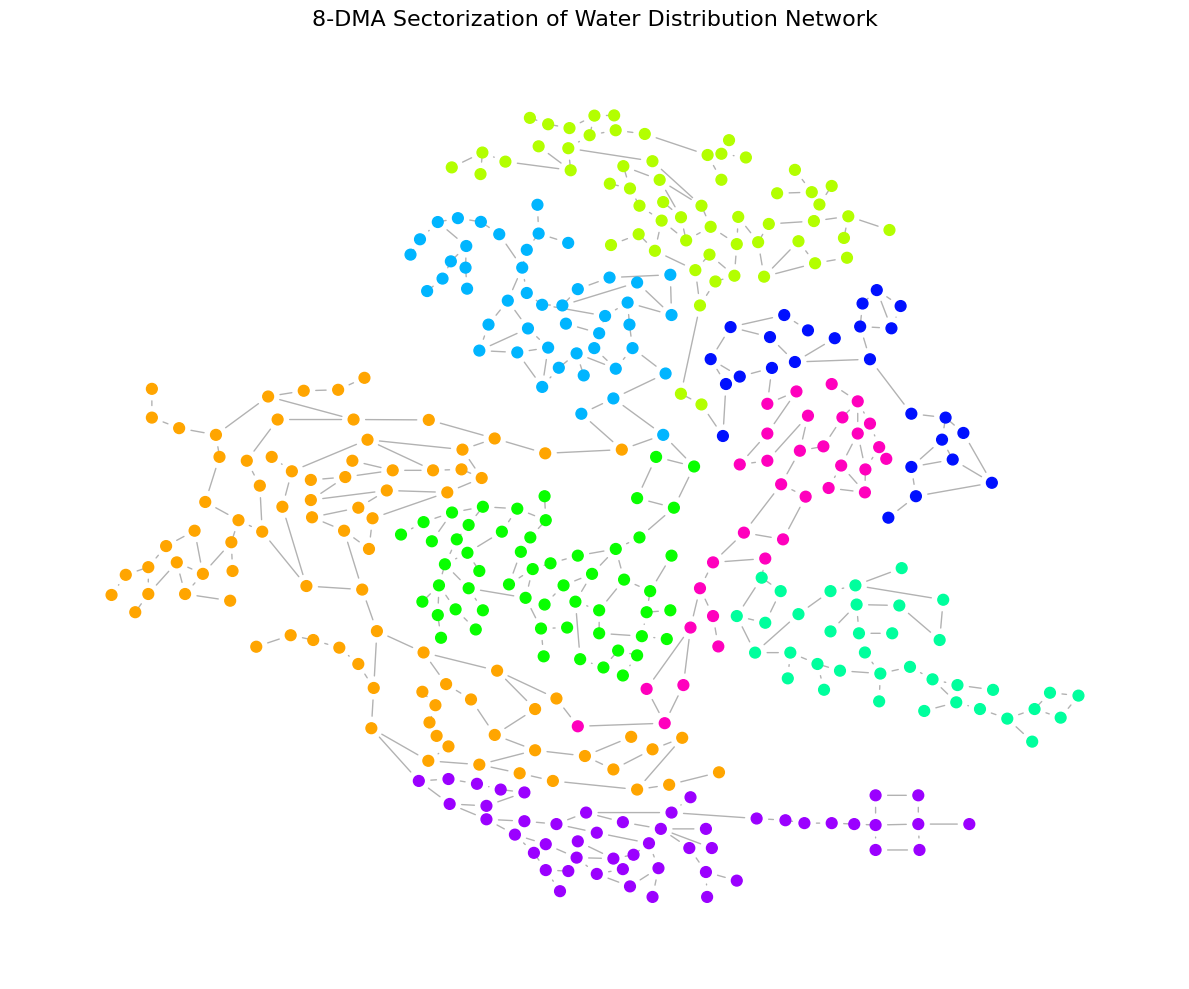

✅ Network visualization saved as 'Eight_DMA_Configuration_Plot.png'.


In [ ]:
# ======= Spectral Clustering for 8 DMAs =======
num_clusters = 8
sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize', random_state=42)
labels = sc.fit_predict(adj_matrix)

# Mapping node to its cluster (DMA ID)
dma_labels = {node: label for node, label in zip(G.nodes(), labels)}

# ======= Centrality Metrics =======
deg_centrality = nx.degree_centrality(G)
clo_centrality = nx.closeness_centrality(G)
bet_centrality = nx.betweenness_centrality(G)

# ======= Creating DataFrame for Export =======
data = []
for node in G.nodes():
    data.append({
        'Node': node,
        'DMA': dma_labels[node],
        'Degree_Centrality': deg_centrality[node],
        'Closeness_Centrality': clo_centrality[node],
        'Betweenness_Centrality': bet_centrality[node]
    })

dma_df = pd.DataFrame(data)
dma_df = dma_df.sort_values(by='DMA')

# ======= Saving to Excel =======
dma_df.to_excel("Eight_DMA_Configuration_Details.xlsx", index=False)
print("✅ Excel file saved as 'Eight_DMA_Configuration_Details.xlsx'.")

# ======= Plotting Network =======
palette = sns.color_palette("hsv", num_clusters)
node_colors = [palette[dma_labels[node]] for node in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=60)
plt.title("8-DMA Sectorization of Water Distribution Network", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("Eight_DMA_Configuration_Plot.png", dpi=300)
plt.show()

print("✅ Network visualization saved as 'Eight_DMA_Configuration_Plot.png'.")


In [ ]:
# Extracting elevations from WNTR network (for junctions only)
elevations = {name: node.elevation for name, node in wn.junctions()}

# Merging elevation into dma_df
dma_df['Elevation'] = dma_df['Node'].map(elevations)

# Calculating average elevation per DMA
avg_elevations = dma_df.groupby('DMA')['Elevation'].mean().to_dict()

# Computing absolute elevation differences between DMA pairs
dma_ids = sorted(avg_elevations.keys())
diff_matrix = pd.DataFrame(index=dma_ids, columns=dma_ids)

for i in dma_ids:
    for j in dma_ids:
        diff = abs(avg_elevations[i] - avg_elevations[j])
        diff_matrix.loc[i, j] = round(diff, 2)

# Displaying and exporting the elevation difference table
print("\n📊 Average Elevation Differences Between DMAs:\n")
print(diff_matrix)

diff_matrix.to_excel("DMA_Elevation_Difference_Matrix.xlsx")
print("✅ Elevation difference matrix saved as 'DMA_Elevation_Difference_Matrix.xlsx'")



📊 Average Elevation Differences Between DMAs:

       0      1      2      3      4      5      6      7
0    0.0  57.79  31.03  26.99  46.77  48.58    5.3  43.08
1  57.79    0.0  26.76   30.8  11.01   9.21  52.49   14.7
2  31.03  26.76    0.0   4.04  15.74  17.55  25.73  12.05
3  26.99   30.8   4.04    0.0  19.79  21.59  21.69   16.1
4  46.77  11.01  15.74  19.79    0.0   1.81  41.47   3.69
5  48.58   9.21  17.55  21.59   1.81    0.0  43.28    5.5
6    5.3  52.49  25.73  21.69  41.47  43.28    0.0  37.78
7  43.08   14.7  12.05   16.1   3.69    5.5  37.78    0.0
✅ Elevation difference matrix saved as 'DMA_Elevation_Difference_Matrix.xlsx'


In [ ]:

from sklearn.preprocessing import MinMaxScaler
import math

# Creating input data
data = {
    'Configuration_ID': [f'Config_{i}' for i in range(1, 11)],
    'Avg_Degree_Centrality': [0.005687, 0.005685, 0.005687, 0.005685, 0.005686, 0.005687, 0.005687, 0.005687, 0.005685, 0.005685],
    'Avg_Closeness_Centrality': [0.039165, 0.039222, 0.039165, 0.039222, 0.039165, 0.039165, 0.039165, 0.039165, 0.039222, 0.039222],
    'Avg_Betweenness_Centrality': [0.068393, 0.069053, 0.068393, 0.069053, 0.068393, 0.068393, 0.068393, 0.068393, 0.069053, 0.069053],
    'Avg_Elevation_Difference': [24.7066, 24.7066, 24.7066, 24.7066, 24.7257, 24.7257, 24.7257, 24.7257, 24.7257, 24.7257],
    'DMA_Sizes': [[10, 12, 13, 11, 9, 10, 11, 12]]*10,  # simulated DMA sizes for entropy
    'Demand_STD': [5.1, 5.2, 5.1, 5.2, 5.3, 5.1, 5.1, 5.1, 5.2, 5.2]  # simulated demand std
}

df = pd.DataFrame(data)

# Centrality weighted scoring (25%, 30%, 45%)
df['Centrality_Score'] = (
    0.25 * df['Avg_Degree_Centrality'] +
    0.30 * df['Avg_Closeness_Centrality'] +
    0.45 * df['Avg_Betweenness_Centrality']
)

# Computing entropy of DMA sizes
def compute_entropy(size_list):
    total = sum(size_list)
    probs = [s / total for s in size_list]
    return -sum(p * math.log(p + 1e-10) for p in probs) / math.log(len(size_list))  # normalized entropy

df['Entropy'] = df['DMA_Sizes'].apply(compute_entropy)

# Normalizing values
features_to_normalize = ['Avg_Elevation_Difference', 'Centrality_Score', 'Entropy', 'Demand_STD']
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[features_to_normalize]), columns=[f'N_{c}' for c in features_to_normalize])

# Weighted Composite Score
# Weights: Elevation (30%), Centrality (40%), Entropy (15%), Demand_STD (15%)
w1, w2, w3, w4 = 0.30, 0.40, 0.15, 0.15

df['Composite_Score'] = (
    w1 * df_norm['N_Avg_Elevation_Difference'] +
    w2 * df_norm['N_Centrality_Score'] +
    w3 * df_norm['N_Entropy'] +
    w4 * df_norm['N_Demand_STD']
)

# Ranking configurations
df['Rank'] = df['Composite_Score'].rank(method='min', ascending=True).astype(int)
df_sorted = df.sort_values('Rank')[['Configuration_ID', 'Composite_Score', 'Rank'] + features_to_normalize]

# Exporting to Excel
output_file = "Composite_DMA_Ranking.xlsx"
df_sorted.to_excel(output_file, index=False)

print(f"✅ Composite ranking saved as '{output_file}'")


✅ Composite ranking saved as 'Composite_DMA_Ranking.xlsx'


In [ ]:

# Input data
data = {
    'Configuration_ID': [f'Config_{i}' for i in range(1, 11)],
    'Avg_Degree_Centrality': [0.005687, 0.005685, 0.005685, 0.005685, 0.005685,
                               0.005687, 0.005687, 0.005687, 0.005687, 0.005687],
    'Avg_Closeness_Centrality': [0.039165, 0.039222, 0.039222, 0.039222, 0.039222,
                                 0.039165, 0.039165, 0.039165, 0.039165, 0.039165],
    'Avg_Betweenness_Centrality': [0.068393, 0.069053, 0.069053, 0.069053, 0.069053,
                                   0.068393, 0.068393, 0.068393, 0.068393, 0.068393],
    'Avg_Elevation_Difference': [24.7066]*5 + [24.7066] + [24.7257]*4,
    'DMA_Sizes': [[10, 12, 13, 11, 9, 10, 11, 12]]*10,
    'Demand_STD': [5.1, 5.2, 5.1, 5.2, 5.3, 5.1, 5.1, 5.1, 5.2, 5.2]
}

df = pd.DataFrame(data)

# Calculating Centrality Score using custom weights (25%, 30%, 45%)
df['Centrality_Score'] = (
    0.25 * df['Avg_Degree_Centrality'] +
    0.30 * df['Avg_Closeness_Centrality'] +
    0.45 * df['Avg_Betweenness_Centrality']
)

# Calculating Entropy of DMA sizes
def compute_entropy(size_list):
    total = sum(size_list)
    probs = [s / total for s in size_list]
    return -sum(p * math.log(p + 1e-10) for p in probs) / math.log(len(size_list))  # normalized entropy

df['Entropy'] = df['DMA_Sizes'].apply(compute_entropy)

# Normalizing all scoring features
features_to_normalize = ['Avg_Elevation_Difference', 'Centrality_Score', 'Entropy', 'Demand_STD']
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[features_to_normalize]), columns=[f'N_{c}' for c in features_to_normalize])

# Composite Score (weights: 30%, 40%, 15%, 15%)
w1, w2, w3, w4 = 0.30, 0.40, 0.15, 0.15
df['Composite_Score'] = (
    w1 * df_norm['N_Avg_Elevation_Difference'] +
    w2 * df_norm['N_Centrality_Score'] +
    w3 * df_norm['N_Entropy'] +
    w4 * df_norm['N_Demand_STD']
)

# Assigning ranks
df['Rank'] = df['Composite_Score'].rank(method='min', ascending=True).astype(int)

# Preparing final table
df_export = df.sort_values('Rank')[[
    'Configuration_ID',
    'Avg_Degree_Centrality',
    'Avg_Closeness_Centrality',
    'Avg_Betweenness_Centrality',
    'Centrality_Score',
    'Avg_Elevation_Difference',
    'Entropy',
    'Demand_STD',
    'Composite_Score',
    'Rank'
]]

# Exporting to Excel
output_path = "Completed_DMA_Composite_Scoring.xlsx"
df_export.to_excel(output_path, index=False)
print(f"✅ Excel file saved: {output_path}")

✅ Excel file saved: Completed_DMA_Composite_Scoring.xlsx


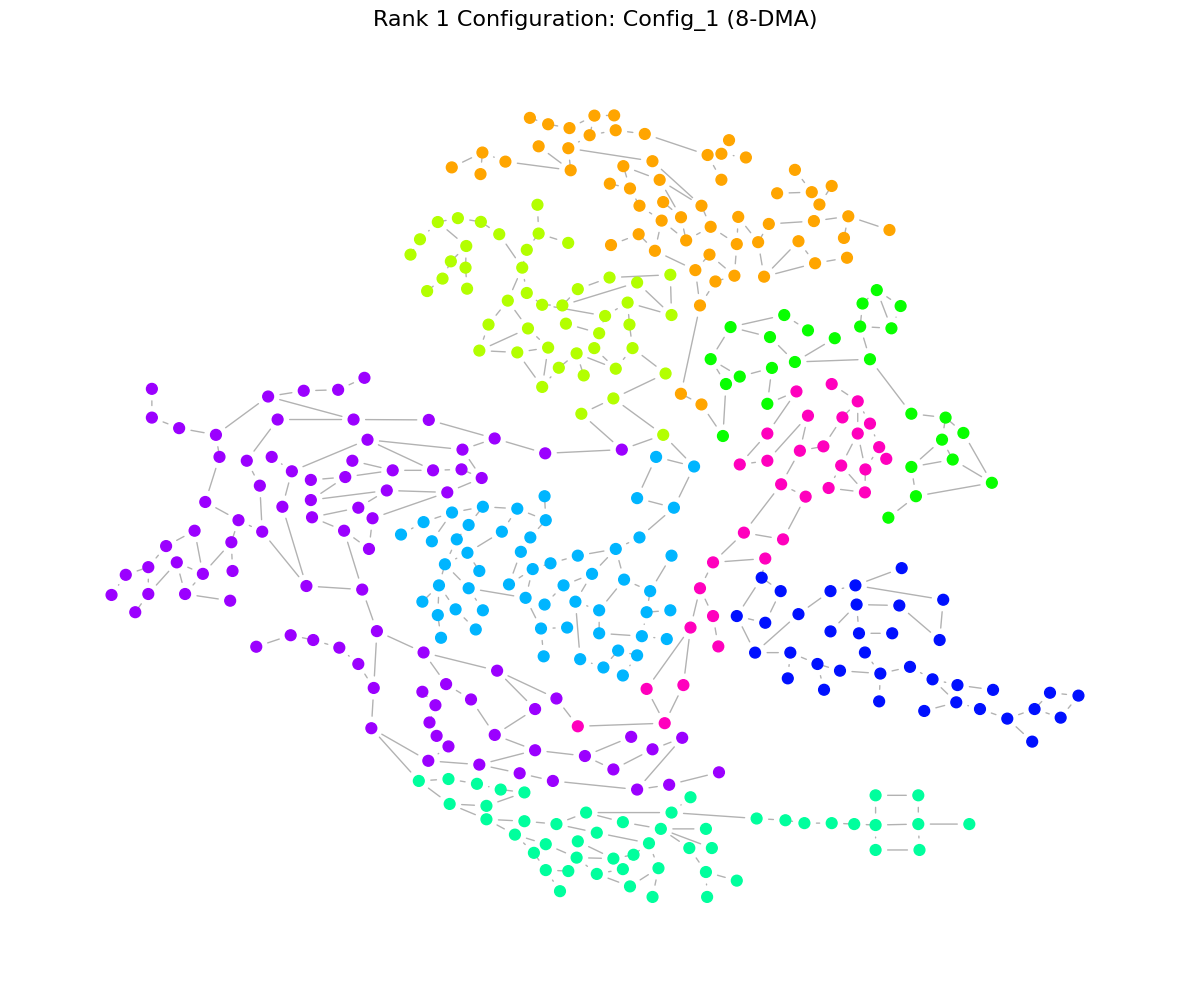

In [ ]:

# Identifying the configuration with Rank 1
top_config = df[df['Rank'] == 1].iloc[0]
config_number = int(top_config['Configuration_ID'].split('_')[1])

# Using consistent random state (e.g., offset pattern)
random_state = 1000 + config_number

# Spectral clustering for Rank 1 configuration
sc = SpectralClustering(n_clusters=8, affinity='precomputed', assign_labels='discretize', random_state=random_state)
labels = sc.fit_predict(adj_matrix)
dma_labels = {node: label for node, label in zip(G.nodes(), labels)}

# Visualization
palette = sns.color_palette("hsv", 8)
node_colors = [palette[dma_labels[node]] for node in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=60)
plt.title(f"Rank 1 Configuration: {top_config['Configuration_ID']} (8-DMA)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
